# Predicting Streamflow Peaks
by Martha Burket (burke781@umn.edu), Carson DeSotel (desot033@umn.edu)  

GEOG 5543  
Fall 2021

## Preparation
The following code cells are used in the preparation of the Notebook. Ensure that you have all needed libraries installed and that all libraries / modules are imported before attempting to run any of the other cells. 

In [44]:
'''
    Installation:
'''
import sys
from IPython.utils import io

print('Installing Needed Libraries...')
with io.capture_output() as captured:
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install requests
    !{sys.executable} -m pip install tensorflow
    !{sys.executable} -m pip install keras
    !{sys.executable} -m pip install sklearn
print('Finished Installation...')

Installing Needed Libraries...
Finished Installation...


In [45]:
'''
    Imports:
'''
### Standard Data Processing Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### SKLearn Imports
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

### Keras Imports
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Data Preparation
The majority of the data has been prepared ahead of time and exported to a csv (final_data_extra_processing.csv) that can simply be imported here. 

Additional processing was needed to normalize values. This wasn't done ahead of time to preserve a true, accurate representation of the data. 

Normalization is done in the following cells to make it easier to compare across years and to fit into the machine learning model later.

In [46]:
'''
    Open Saved Data & Validate
'''
final_data = pd.read_csv('final_data_extra_processing.csv')

### Convert Dates column to DateTime type
final_data['Dates'] = pd.to_datetime(final_data['Dates'], utc = True)
final_data.head(5)

,Dates,Temp (F),RH (%),Wind Spd (mph),Precip (in),Flow (ft^3 / s),Sample Flow,24hr Precip
0,2012-04-02 11:00:00+00:00,62,47,28,0.0,68.0,71.9,0.0
1,2012-04-02 12:00:00+00:00,67,47,24,0.0,65.4,71.9,0.0
2,2012-04-02 13:00:00+00:00,69,47,24,0.0,65.4,71.9,0.0
3,2012-04-02 14:00:00+00:00,69,48,23,0.0,66.7,71.9,0.0
4,2012-04-02 15:00:00+00:00,69,50,18,0.0,66.7,71.9,0.0


In [47]:
'''
    Normalize Values:
    DO NOT RUN MORE THAN ONCE
'''

### Normalize RH by dividing by 100 to fit in range [0, 1]
final_data['RH (%)'] = final_data['RH (%)'].apply(lambda x: x / 100)

### Normalize Temp 
final_data['Temp (F)'] = final_data['Temp (F)'].apply(lambda x: x / 100)

### Normalize Precipitation
precip_max = final_data['Precip (in)'].max()
final_data['Precip (in)'] = final_data['Precip (in)'].apply(lambda x: x / precip_max)

### Normalize 24 hr cumulative precipitation
cuma_precip_max = final_data['24hr Precip'].max()
final_data['24hr Precip'] = final_data['24hr Precip'].apply(lambda x: x / cuma_precip_max)

### Normalize Wind Speed
wind_max = final_data['Wind Spd (mph)'].max()
final_data['Wind Spd (mph)'] = final_data['Wind Spd (mph)'].apply(lambda x: x / wind_max)

### Normalize Flow using Min-Max Normalization
flow_max = final_data['Flow (ft^3 / s)'].max()
flow_min = final_data['Flow (ft^3 / s)'].min()

final_data['Flow (ft^3 / s)'] = final_data['Flow (ft^3 / s)'].apply(lambda x: (x - flow_min) / (flow_max - flow_min))

### Normalize Sample flow using Min-Max normalization
final_data['Sample Flow'] = final_data['Sample Flow'].apply(lambda x: (x - flow_min) / (flow_max - flow_min))

## Normalized Value Visualization

Streamflow, Precipitation, and Wind Speed are the three most impactful variables in our examination of streamflow prediction. The following cells plot each year's normalized values against each other to illustrate how they compare.

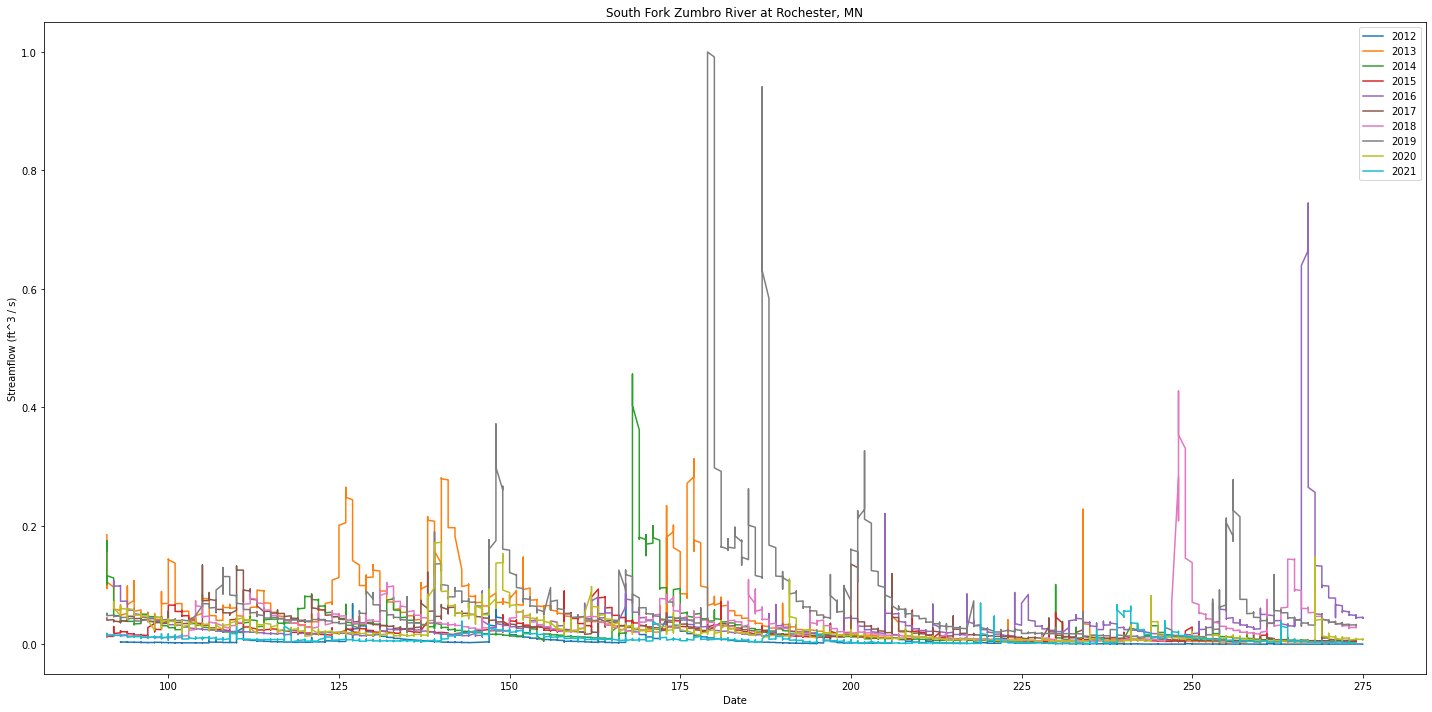

In [48]:
'''
    Plot Normalized Flow
'''

df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Streamflow (ft^3 / s)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Flow (ft^3 / s)'], label=str(2012 + index))
    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()


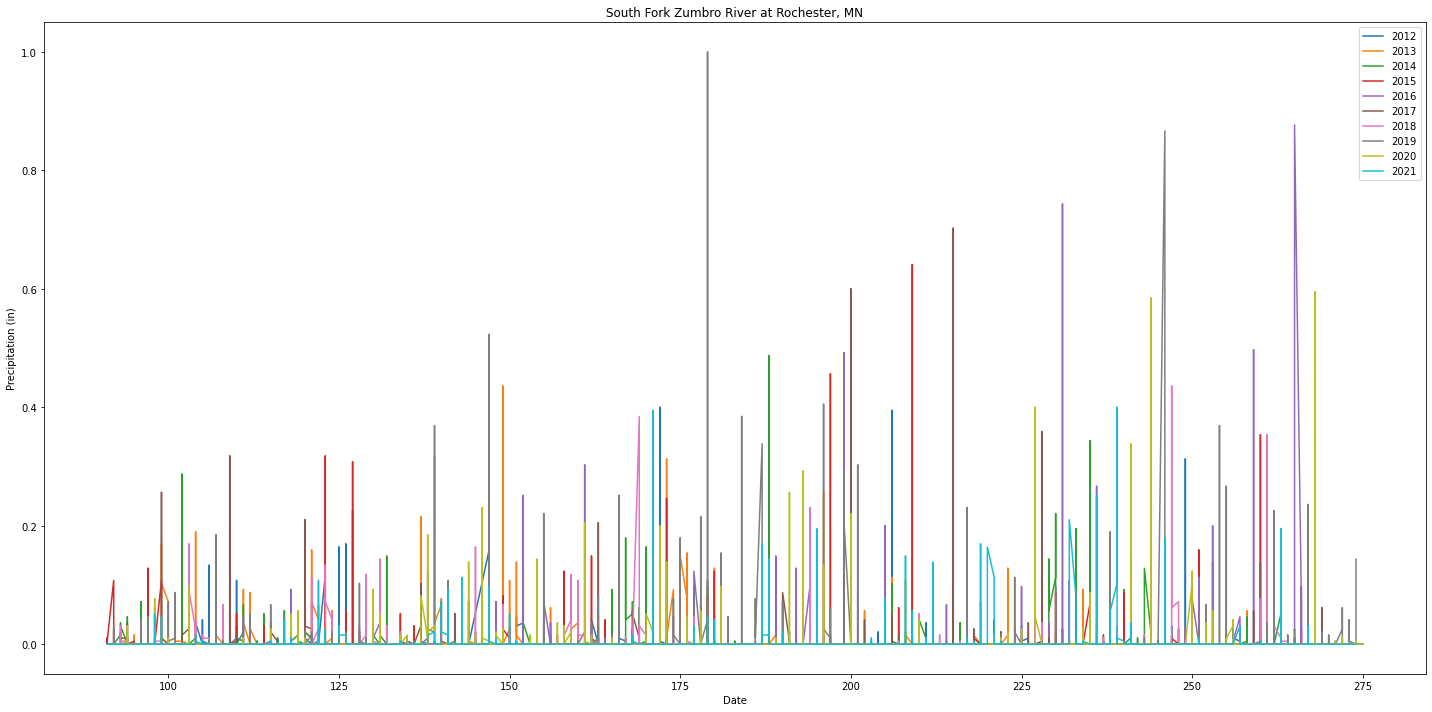

In [49]:
'''
    Display Precipitation
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column'Precip (in)'
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Precip (in)'], label=str(2012 + index))    
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

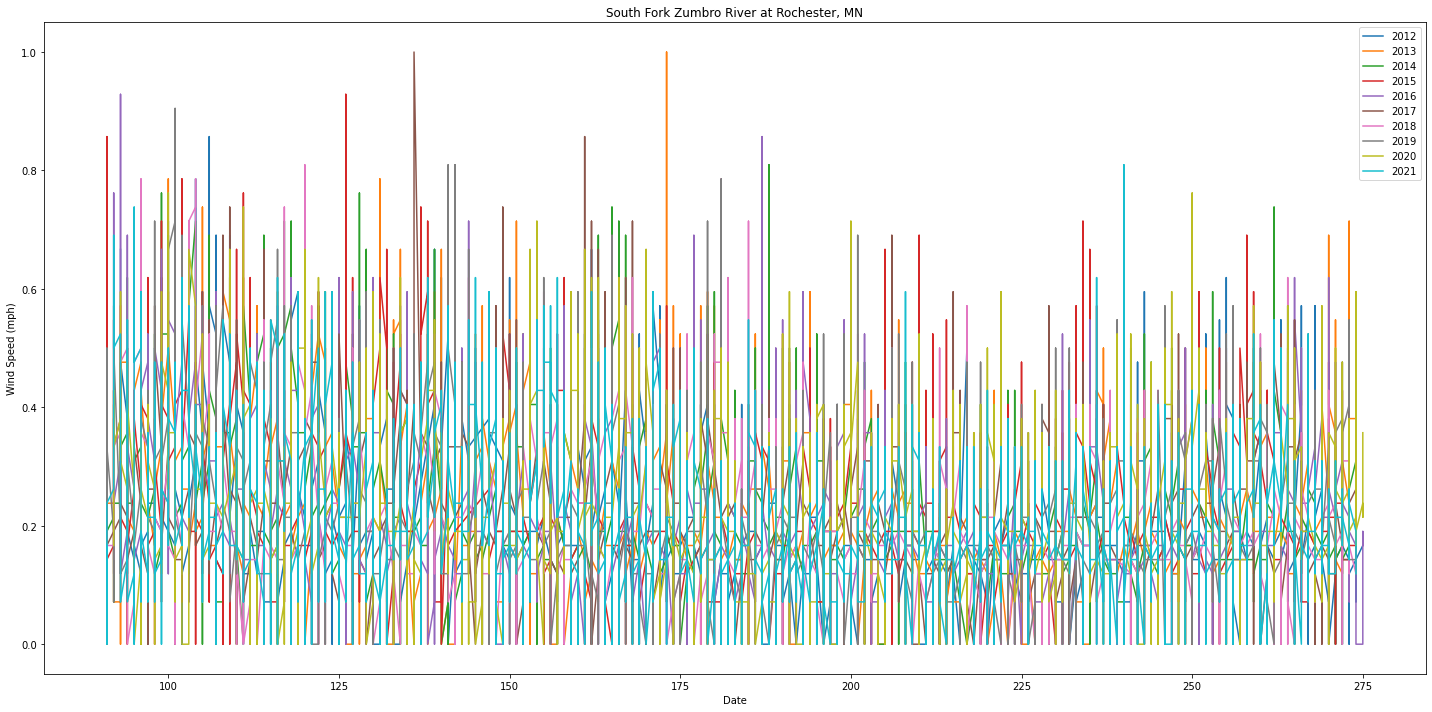

In [50]:
'''
    Display Normalized Wind Speed
'''
df_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(final_data[final_data['Dates'].dt.year == year].copy(deep = True))
    year += 1

plt.figure(figsize=(20, 10))
plt.title('South Fork Zumbro River at Rochester, MN')
plt.xlabel('Date')
plt.ylabel('Wind Speed (mph)')

index = 0
for df in df_arr:
    ### Remove Year From Datetime 'Dates' Column
    df['DayOfYear'] = df['Dates'].dt.dayofyear
    
    ### Plot Each DataFrame
    plt.plot(df['DayOfYear'], df['Wind Spd (mph)'], label=str(2012 + index))
    index += 1

plt.tight_layout()
plt.legend()
plt.show()

## Machine Learning

This section shows the process we're using to create and execute the machine learning model. 

Generally, we're using the Temperature, Relative Humidity, Wind Speed, Precipitation, Streamflow, and Day of Year to predict the streamflow for the next day. Because the data is a multivariate time series, we decided that an LSTM (Long Short-Term Memory) approach would be the most beneficial, as it is capable of accurately measuring values of a time series over long spans of time. 

In our investigation of the streamflow data, we found that there were days at a time where there was no streamflow data presented. We assume this to be due to maintenance on the gauges, and the affected rows were dropped.

In [51]:
'''
    Use & Normalize DayOfYear to influence Model
'''
# add day of year to final data frame
final_data['DayOfYear'] = final_data['Dates'].dt.dayofyear

# normalize
final_data['DayOfYear'] = final_data['DayOfYear']/366

In [52]:
'''
    Display Final Data
'''

### Large Pretty Print of DF
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#      print(final_data[:5000])

### Just get head to reduce display size in GitHub
print(final_data.head())

                      Dates  Temp (F)  RH (%)  Wind Spd (mph)  Precip (in)  \
0 2012-04-02 11:00:00+00:00      0.62    0.47        0.666667          0.0   
1 2012-04-02 12:00:00+00:00      0.67    0.47        0.571429          0.0   
2 2012-04-02 13:00:00+00:00      0.69    0.47        0.571429          0.0   
3 2012-04-02 14:00:00+00:00      0.69    0.48        0.547619          0.0   
4 2012-04-02 15:00:00+00:00      0.69    0.50        0.428571          0.0   

   Flow (ft^3 / s)  Sample Flow  24hr Precip  DayOfYear  
0         0.003713     0.004042          0.0   0.254098  
1         0.003494     0.004042          0.0   0.254098  
2         0.003494     0.004042          0.0   0.254098  
3         0.003604     0.004042          0.0   0.254098  
4         0.003604     0.004042          0.0   0.254098  


In [71]:
'''
    Define a function to reshape the data to fit with Keras' LSTM module
    Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
'''
def series_to_supervised(df, n_in=1, n_out=1,dropnan=True):
    '''
        convert a data frame to an appropriate data format for Keras
        :param df: a pandas DataFrame to process
        :param n_in: the number of input series
        :param n_out: the number of output series
        :param dropnan: (T/F) whether to drop NaN values
        :return: a new DataFrame that has been fit with appropriate data
    '''
    n_vars = len(df.columns)
    cols, names = list(), list()
    
    ### move range of inputs to define an input sequence (t - n_in .. t - 1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        ### Set column names based on shift
        names += [('%s (t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
        
    ### move range of inputs to define a forecase sequence (t .. t + n_out)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        
        ### Set column names based on shift
        if i == 0:
            names += [('%s (t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s (t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    
    ### join names w/ cols
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    ### delete discontinuous rows of data - THIS WILL NOT WORK WHEN n_hours > 1
    agg['DayDiff'] = agg['DayOfYear (t-1)'].diff()
    agg = agg[abs(agg['DayDiff']) <= 1/366]        # only keep continuous dates
    agg.drop(columns=['DayDiff'],inplace=True)     # remove DayDiff

    ### drop any NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [94]:
'''
    Process input data to fit with model
'''
### create input set, retaining dates
input_set = final_data.loc[:, :'DayOfYear']

#n_hours = 3
n_features = 5

### fit input_set to model
reframed = series_to_supervised(input_set,1,1)

### remove unwanted columns
### Retain sample data, cumulative precip, dates, and other useful prediction data; n_hours = 1
reframed.drop(reframed.columns[[5,9,10,11,12,13,15,16,17]], axis = 1, inplace = True) # with dates

print(reframed.head())  # show result

RangeIndex(start=0, stop=43304, step=1)
                Dates (t-1)  Temp (F) (t-1)  RH (%) (t-1)  \
2 2012-04-02 12:00:00+00:00            0.67          0.47   
3 2012-04-02 13:00:00+00:00            0.69          0.47   
4 2012-04-02 14:00:00+00:00            0.69          0.48   
5 2012-04-02 15:00:00+00:00            0.69          0.50   
6 2012-04-02 16:00:00+00:00            0.71          0.50   

   Wind Spd (mph) (t-1)  Precip (in) (t-1)  Sample Flow (t-1)  \
2              0.571429                0.0           0.004042   
3              0.571429                0.0           0.004042   
4              0.547619                0.0           0.004042   
5              0.428571                0.0           0.004042   
6              0.380952                0.0           0.004042   

   24hr Precip (t-1)  DayOfYear (t-1)  Flow (ft^3 / s) (t)  
2                0.0         0.254098             0.003494  
3                0.0         0.254098             0.003604  
4                0.

In [95]:
'''
    Define Training & Testing Data Sets
    
    Removes discontinuities where the stream gauge was out of commission
'''
### preserve Dates w/ dropped values for later
dates = reframed['Dates (t-1)']
reframed.drop(['Dates (t-1)'], axis = 1, inplace = True)

values = reframed.values

### Get locations of turnover points in the data set -- goes to a new year
### note that there are a few full days of missing data - stream gauge out of commission
reframed['DayDiff'] = reframed['DayOfYear (t-1)'].diff()
yr_idx = reframed.index[abs(reframed['DayDiff'])>30/366].tolist()
split_idx = yr_idx[6] # where to split the training/validation data

### split into training and validation data
reframed.drop(columns=['DayDiff'],inplace=True)
train = values[:split_idx,:]
test = values[split_idx:,:]

### get input and prediction datasets
# NB: the indexing here needs to be adjusted to pull out the streamflow data!!
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

### reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

41548
(30230, 1, 7) (30230,) (11318, 1, 7) (11318,)


In [90]:
'''
    Create the model
'''
n_epochs = 75

### design the model
model = Sequential()
model.add(LSTM(n_epochs, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam') # can change loss & optimizer

### run model for n_epochs
print('Running', n_epochs, 'tests...')
with io.capture_output() as captured:
    history = model.fit(train_X, train_y, epochs=50, batch_size=96, validation_data=(test_X, test_y), verbose=2, shuffle=False)
print('Finished running tests...')

Running 75 tests...
Finished running tests...


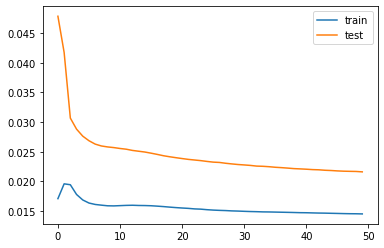

In [91]:
### plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Results
The following cells demonstrate piecing the data back together after splitting it into training and testing data sets. We compare each year's predicted and real streamflow in subgraphs to allow for better visualization and reduce discontinuities between years, as the entire year was not measured. 

In [111]:
'''
    Create Final Data Frame
'''
import numpy as np

### get model prediction from training data
yhat = model.predict(train_X, verbose=0)
yhat = np.concatenate(yhat, axis=0)

yhat_test = model.predict(test_X, verbose=0)
yhat_test = np.concatenate(yhat_test, axis=0)

### merge prediction with testing data to have a contiguous final data frame
streamflow  = pd.concat([pd.Series(train_y), pd.Series(test_y)])
prediction = pd.concat([pd.Series(yhat), pd.Series(yhat_test)])

### convert inputs to dictionary
d_results = { 'Dates' : dates.to_numpy(), 
              'Streamflow (ft^3/s)' : streamflow, 
              'Prediction' : prediction
            }

### create DataFrame from inputs
results = pd.DataFrame(d_results)
results.dropna(inplace = True)

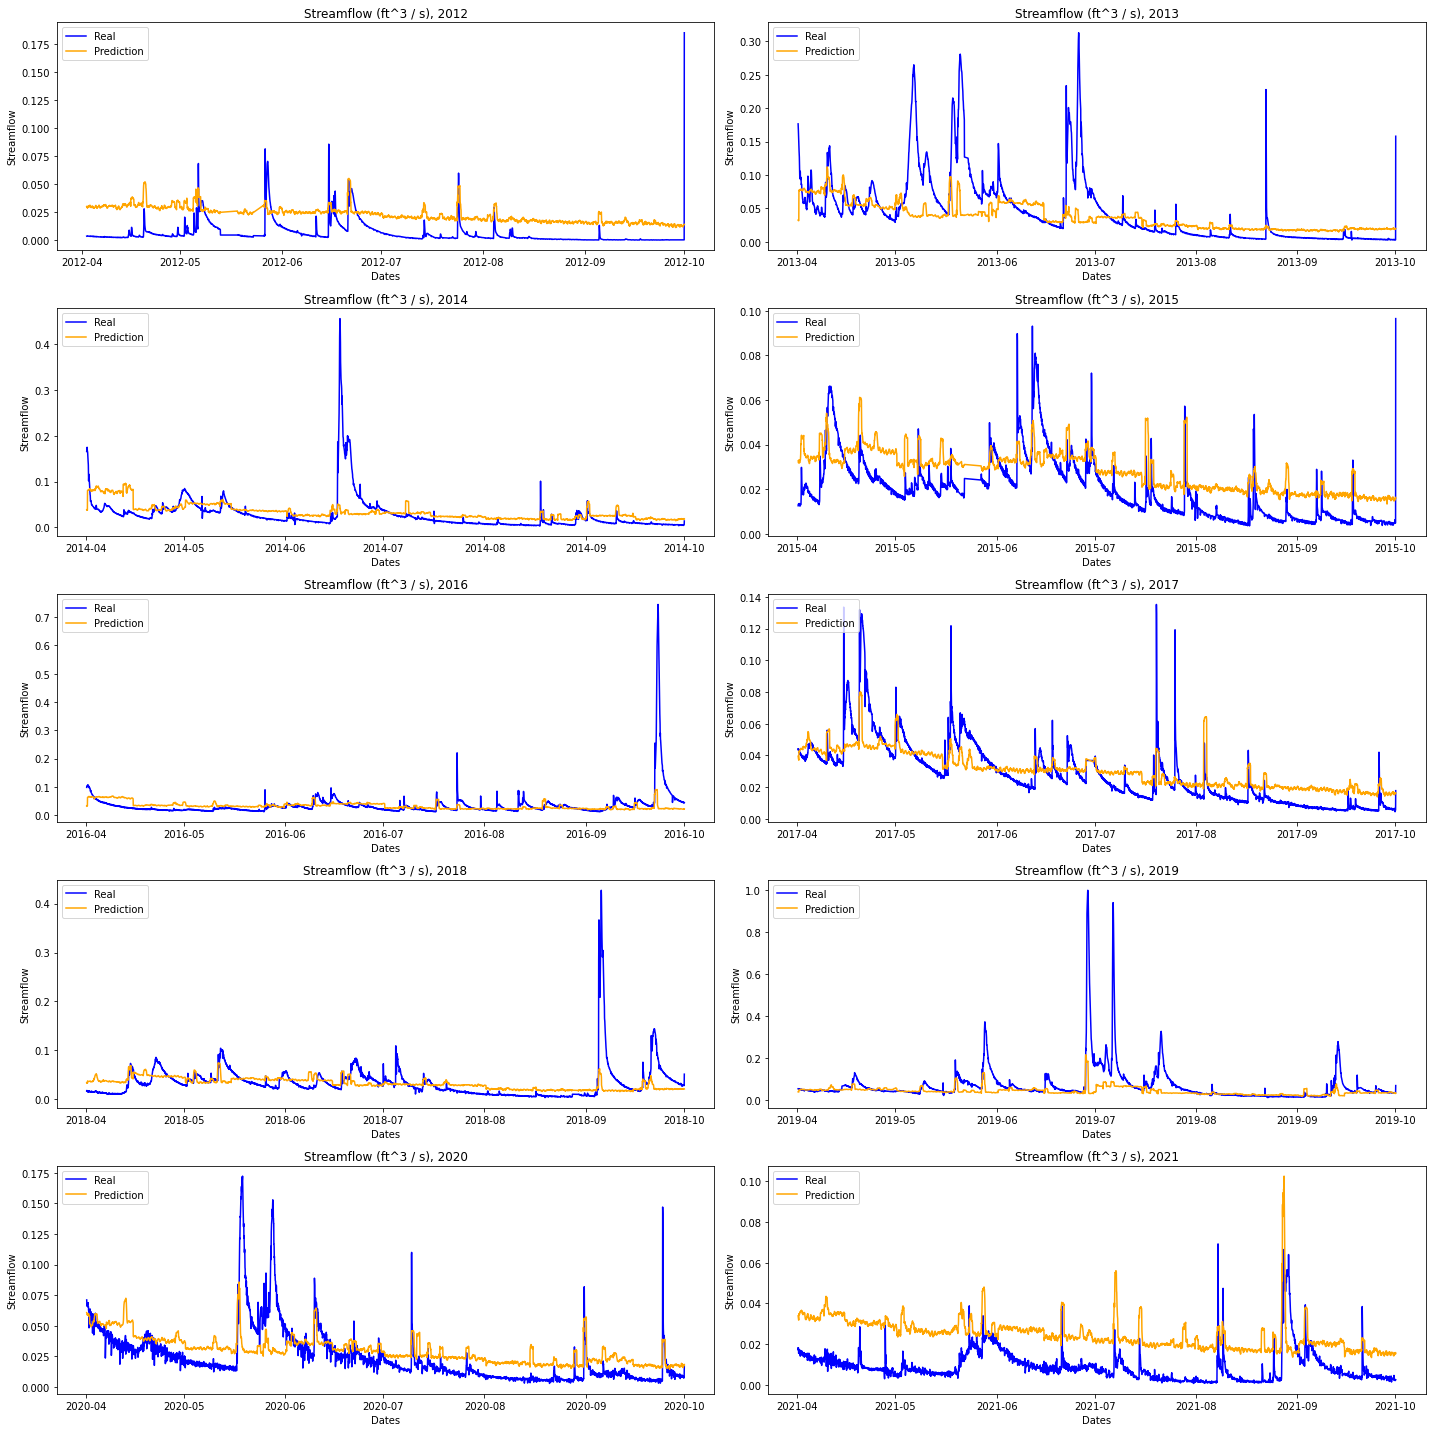

In [112]:
'''
    Split Prediction & Read Charts by Year
'''
fig, axes = plt.subplots(nrows = 5,
                        ncols = 2, 
                        figsize = (20, 20))
ax = axes.ravel()

df_arr = []
predict_arr = []

year = 2012
### Split DF by years
while year < 2022:
    df_arr.append(results[results['Dates'].dt.year == year].copy(deep = True))
    year += 1

index = 0
for df in df_arr:    
    ### Plot Each DataFrame
    ax[index].set_xlabel('Dates')
    ax[index].set_ylabel('Streamflow')
    ax[index].set_title('Streamflow (ft^3 / s), ' + str(2012 + index))
    ax[index].plot(df['Dates'], df['Streamflow (ft^3/s)'], color='blue', label='Real')
    ax[index].plot(df['Dates'], df['Prediction'], color='orange', label='Prediction')
    ax[index].legend(loc = 'upper left')
    index += 1

plt.tight_layout()
plt.show()

### References
[1] https://www.earthdatascience.org/tutorials/acquire-and-visualize-usgs-hydrology-data/  
[2] https://waterservices.usgs.gov/rest/IV-Service.html  
[3] https://www.ogc.org/standards/waterml  
[4] https://docs.python-requests.org/en/latest/user/quickstart/  
[5] https://www.usgs.gov/special-topic/water-science-school/science/how-streamflow-measured?qt-science_center_objects=0#qt-science_center_objects  
[6] https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/